# Описание задачи

Данная задача на бинарную классификацию.

**Цель:**
В данной задаче нам нужно предсказать подвержен пациент сердечному приступу или нет.


Задача взята с соревновательной платформы kaggle: https://www.kaggle.com/datasets/nareshbhat/health-care-data-set-on-heart-attack-possibility

**Имеющиеся данные:**
+ age - возраст
+ sex - пол (1 = муж; 0 = жен)
+ cp - тип боли в груди
+ trestbps - кровяное давление в состоянии покоя
+ chol - сыворочный холесторал в mg/dl
+ fbs > 120 mg/dl - уровень сазара в крови натощак
+ restecg  - результаты электрокардиографии в состоянии покоя (значения 0,1,2)
+ thalach - максимальная частота сердечных сокращений
+ exang - стенокардия, вызванная физической нагрузкой
+ oldpeak = ST depression induced by exercise relative to rest
+ slope - the slope of the peak exercise ST segment
+ ca - number of major vessels (0-3) colored by flourosopy
+ thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
+ target - целевая : 0 - шансы приступа малы, 1 - шансы приступа велики

# Начало работы

## Подключение библиотек

In [284]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import time
from math import ceil

from sklearn.preprocessing import StandardScaler

from scipy.stats import chisquare, chi2_contingency, ttest_ind, probplot

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer

%matplotlib inline
sns.set(rc={"figure.figsize": (20, 20)})
sns.set_style("whitegrid")

## Функции и переменные



In [285]:
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров
TRESHOLD_FOR_CORR = 0.1 #порог значения корреляции, ниже которого будем отбрасывать признаки
TRESHOLD_FOR_HIGH_CORR = 0.6 #при этом пороге корреляции будем тщательнее исследовать на предмет выбросов
TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE = 0.8 #если корреляция выше - удаляемм один из коррелируемых признаков 
COLOR_PLOT = 'deepskyblue'

def add_into_list(list_el, new_el):
    """
    Функция добавления списка элементов в массив
    """
    if np.isin(new_el, list_el).sum() == 0:
        return np.append(list_el, new_el)
    else:
        return list_el
    
def del_from_list(list_el, new_el):
    """
    Функция удаления элементов из массива
    """
    if np.isin(new_el, list_el).sum():
        return np.setdiff1d(list_el, new_el)
    else:
        return list_el
    
def ksi(data, X, Y):
    for i, j in zip(X, Y):

        CrosstabResult = pd.crosstab(index=data[i], columns=data[j])
        
        ChiSqResult = chi2_contingency(CrosstabResult)
        print(f"P-Value χ² теста между группами {i} и {j} = {ChiSqResult[1]}\n")

## Загрузка данных

In [286]:
data = pd.read_csv('data/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Основная информация о данных

In [287]:
print('Форма тренировочной выборки: ' + str(data.shape))

Форма тренировочной выборки: (303, 14)


In [288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Типы соответствуют, пропущенных значений нет, категориальные признаки: sex, cp, fbs, restecg, exang, slope, ca, thal

## Проверка на дубликаты

In [289]:
print(f'Дубликаты в выборке: {data.duplicated().sum()} ({np.round(100*data.duplicated().sum()/data.shape[0],2)}%)')

Дубликаты в выборке: 1 (0.33%)


In [290]:
dupl = data[data.duplicated()]
dupl

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [291]:
data[data.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


Похоже, что ошибочно внесли две подряд записи (id идут подряд) - удалим дубли

In [292]:
data.drop_duplicates(inplace=True)

# Анализ целевой переменной

Здесь мы рассмотрим на сколько сбалансированы наши классы целевой переменной

In [293]:
val_counts = data.target.value_counts()
val_counts

1    164
0    138
Name: target, dtype: int64

In [294]:
predispos = data[data.target == 1].shape[0]
predispos

164

In [295]:
not_predispos = data.shape[0] - predispos
not_predispos

138

Воспользуемся χ² для оценки равномерности распределения классов

In [296]:
ChiSqResult = chisquare([predispos, not_predispos])
print( f"P-Value χ² теста между группами  = {ChiSqResult[1]}\n")

P-Value χ² теста между группами  = 0.1346192922452585



p-value < 0.05, поэтому гипотеза нулевая о равномерности выборок не отвергается

Text(0.5, 1.0, 'Распределение целевой переменной')

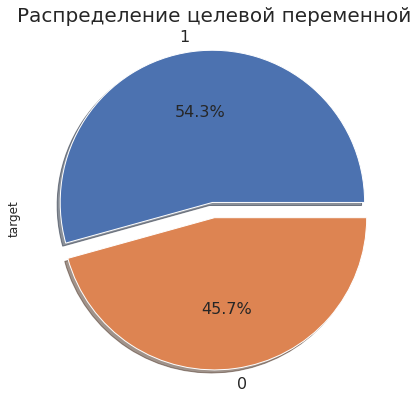

In [297]:
plt.figure(figsize=(7,7))
data.target.value_counts().plot.pie(explode=[0.1,0.001], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).\
    set_title('Распределение целевой переменной', fontsize=20)

Визуально некоторый дисбаланс виднеется, поэтому использовать будем только метрики f score (не accuracy) + стратифицировання валидация

# Типы данных

In [298]:
data.dtypes.value_counts()

int64      13
float64     1
dtype: int64

у нас только числовые признаки, посмотрим на количество разных значений каждого признака, чтоб определиться с категориальными и количественными признаками

In [299]:
dtypes_count = pd.DataFrame({'count': data.nunique(), 'dtype': data.dtypes}, index=data.columns)
dtypes_count

,count,dtype
age,41,int64
sex,2,int64
cp,4,int64
trestbps,49,int64
chol,152,int64
fbs,2,int64
restecg,3,int64
thalach,91,int64
exang,2,int64
oldpeak,40,float64


Видим, что категориальные признаки, это: sex, cp, fbs, restecg, exang, slope, ca, thal + целевая

## Категориальные признаки

Отберем категориальные признаки

In [300]:
cols_cat = dtypes_count[dtypes_count['count'] < 10].index.to_list()
cols_cat = [col for col in cols_cat if col != 'target']
cols_cat

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

проверим значения категориальных признаков:

In [301]:
for col in cols_cat:
    print(col, ':', data[col].unique())

sex : [1 0]
cp : [3 2 1 0]
fbs : [1 0]
restecg : [0 1 2]
exang : [0 1]
slope : [0 2 1]
ca : [0 2 1 3 4]
thal : [1 2 3 0]


По описанию задачи значения ca 0-3, thal 0-2, посмотрим сколько значений, выходящих за границы условия:

In [302]:
data[data.ca == 4]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
92,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
251,43,1,0,132,247,1,0,143,1,0.1,1,4,3,0


In [303]:
# проверим, нет ли дублей за исключение колонки ca - вдруг ошибочно значение 4
data[[col for col in data.columns if col != 'ca']].duplicated().sum()

0

Дублей без признака ca нет, значений ca=4 целых 4, это большое число для малого общего числа наблюдений 302, пока оставим для дальнейшего анализа 

In [304]:
data[data.thal == 3].shape[0]

117

наблюдений со значением thal == 3 более трети, однозначно ошибка в условии.

## Количественные признаки

In [305]:
cols_num = dtypes_count[dtypes_count['count']>=10].index.to_list()
cols_num

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [306]:
data[cols_num].describe()

,age,trestbps,chol,thalach,oldpeak
count,302.00000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,131.602649,246.500000,149.569536,1.043046
std,9.04797,17.563394,51.753489,22.903527,1.161452
min,29.00000,94.000000,126.000000,71.000000,0.000000
25%,48.00000,120.000000,211.000000,133.250000,0.000000
50%,55.50000,130.000000,240.500000,152.500000,0.800000
75%,61.00000,140.000000,274.750000,166.000000,1.600000
max,77.00000,200.000000,564.000000,202.000000,6.200000


Видим подозрительно большие значения у признаков chol и oldpeak - возможны выбросы. Так же отметим, что возраст пациентов колеблется от 29 до 77 лет.

# Анализ категориальных переменных

## Распределение признаков

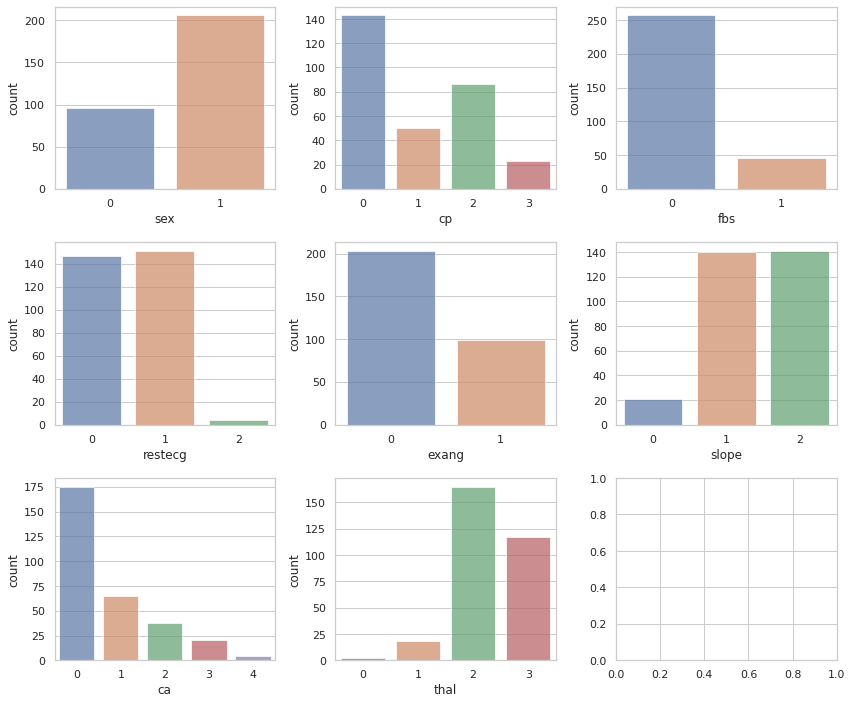

In [307]:
fig, axes = plt.subplots(ceil(len(cols_cat)/3), 3, figsize=(12,10))
for y, col in enumerate(cols_cat):
    i, j = divmod(y, 3)
    sns.countplot(data=data, x=col, ax=axes[i,j], alpha=0.7)
fig.tight_layout()

По графикам видим, что thal=0 очень мало, посмотрим какое число записей с таким значением, может выброс?

In [308]:
data[data.thal == 0]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0


2 записи, пока не будем относить к выбросам 

## Влияние признаков на целевую переменную

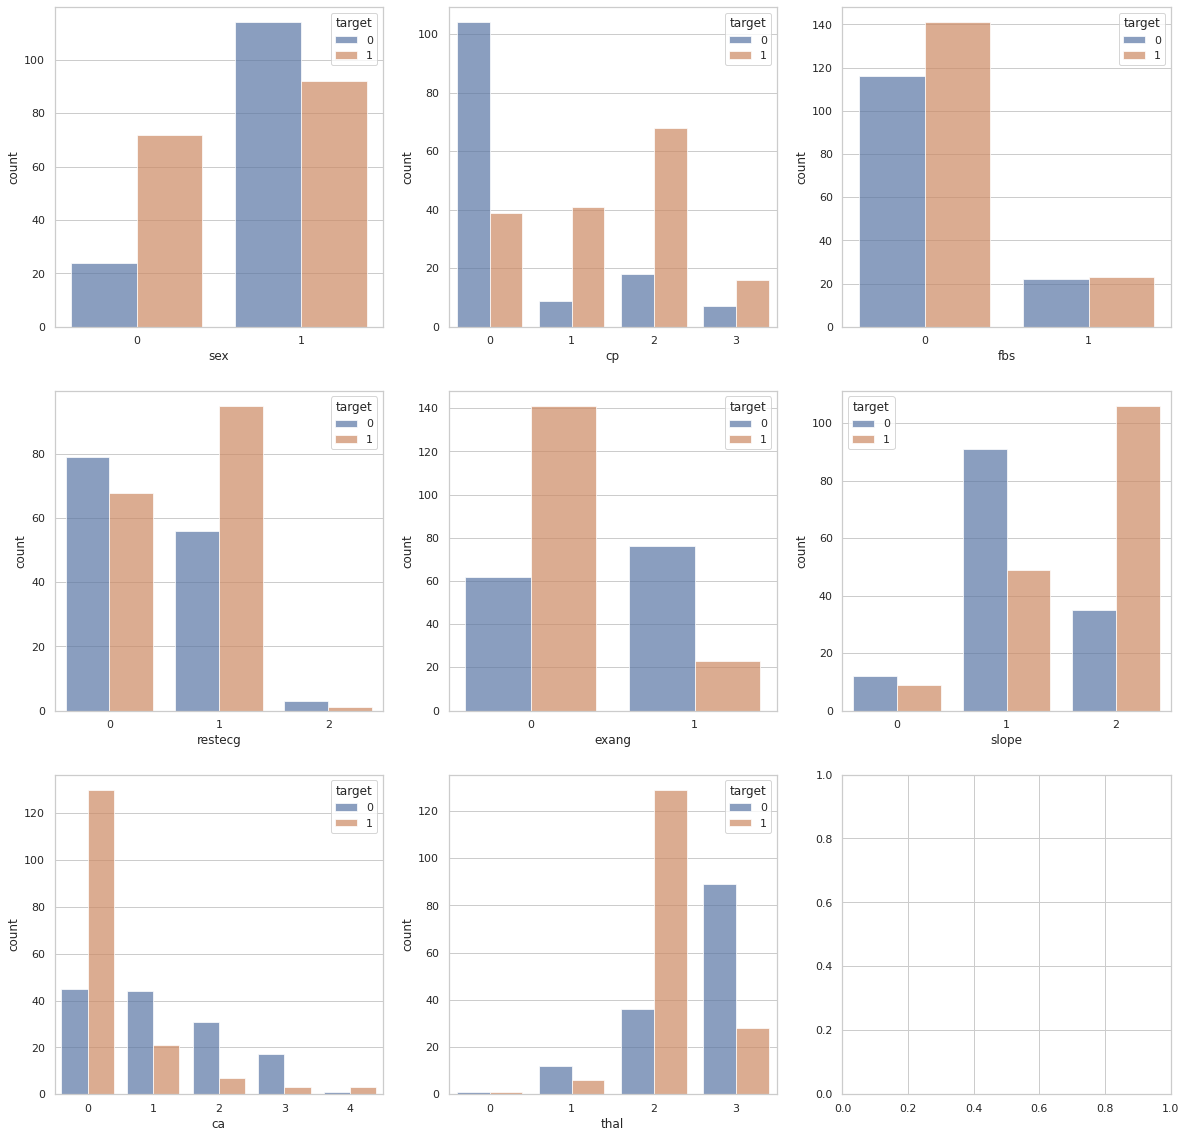

In [309]:
fig, axes = plt.subplots(ceil(len(cols_cat)/3), 3, figsize=(20,20))
for y, col in enumerate(cols_cat):
    i, j = divmod(y, 3)
    sns.countplot(data=data, x=col, hue='target', alpha=0.7, ax=axes[i,j])

По графикам можно сделать следующие выводы:
+ женщины (sex=0) намного больше мужчин подвержены приступу
+ cp = 0 - меньше всего шансов приступа, при cp>0 шансы приступа в несколько раз выше, чем если его не будет
+ fbs меньше всего влияет, но тем не менее влияние есть: если fbs=0 - шанс приступа выше, при fbs шансы примерно равны
+ При restecg = 1 шансов приступа больше всего
+ exang = 0 резко повышает шансы приступа
+ slope = 2 резко повышает шансы приступа
+ ca=0 резко повышает шансы приступа
+ thal = 2 резко повышает шансы приступа

Мы видим довольно сильную зависимость целевой переменной от категориальных признаков. На всякий случай проведем тест χ² для проверки равномерно распределен наш признак целевой по fbs или нет

## Проверка зависимости целевой переменной

Проведем χ² тест для того, чтоб понять на сколько равномерно распределение целевого признака по значениям fbs

In [310]:
CrosstabResult = pd.crosstab(index=data['fbs'], columns=data.target)
ChiSqResult = chi2_contingency(CrosstabResult)
print(f"P-Value χ² теста между группами {col} и target = {ChiSqResult[1]}\n")


P-Value χ² теста между группами thal и target = 0.7611374700928197



По результатам теста видим, что наши признаки с большей доли вероятности распределены независимо, поэтому признак fbs можно исключить из дальнейшего анализа

In [311]:
col_for_del = ['fbs']
data.drop(col_for_del, axis=1, inplace=True)
cols_cat = del_from_list(cols_cat, col_for_del)

## Взаимосвязь между признаками

Посмотрим на графиках, как связаны некоторые категориальные признаки друг с другом

**sex**


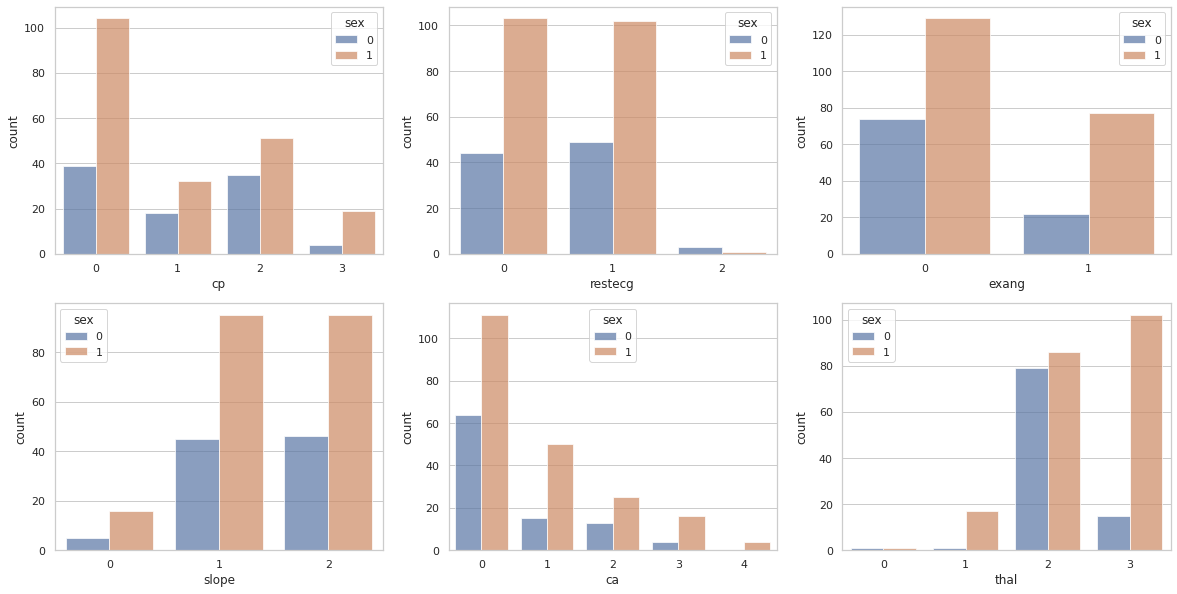

In [312]:
cols = ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(ceil(len(cols)/3), 3, figsize=(20,10))
for y, col in enumerate(cols):
    i, j = divmod(y, 3)
    sns.countplot(data=data, x=col, hue='sex', alpha=0.7, ax=axes[i, j])

По графикам не отмечается сильной корреляции между признаками. Хотя взаимосвязь имеется, например:
+ У денчщин чаще cp=3, чем у мужчин
+ у мужчин чаще restecg=2, чем у женщин
+ у женщин чаще exang=1, чем у мужчин
+ slope и ca прмерно одинаково распределены между мужчинами и женщинами
+  почти все мужчины имеют  thal=2, женщины меньше мужчин склонны к этому значению, зато гораздо более склонны к значениям thal=3 и thal=1. 

Сформируем гипотезы по графикам:
+  H0: sex и остальные категориальные признаки распределены равномерно


In [313]:
X = ['sex'] * 6
Y = ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal']
ksi(data, X, Y)

P-Value χ² теста между группами sex и cp = 0.06875893200193164

P-Value χ² теста между группами sex и restecg = 0.15655216401735997

P-Value χ² теста между группами sex и exang = 0.01820392572039428

P-Value χ² теста между группами sex и slope = 0.7153051408777256

P-Value χ² теста между группами sex и ca = 0.11757841862109845

P-Value χ² теста между группами sex и thal = 8.669405046711333e-10



По тестам видим, что равномеренее всего признак sex распределен с признаком slope. Так же гипотеза о равномерности не отвергается для признака sex с restecg и ca.

Сильнее всего взаимосвязь у признака sex с thal.

**thal**

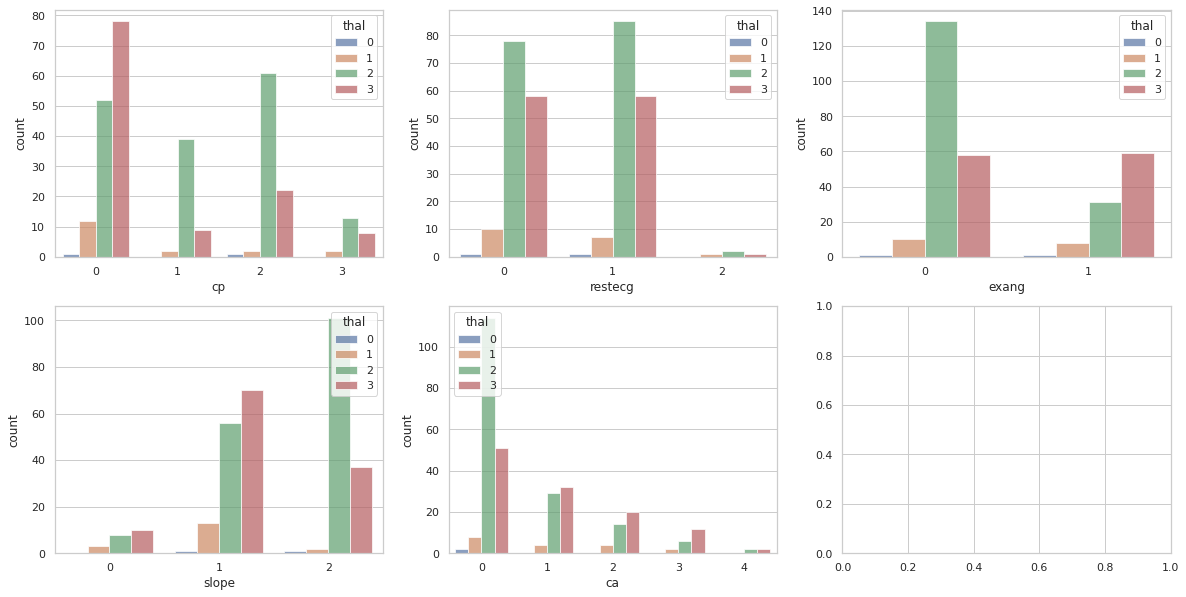

In [314]:
cols = ['cp', 'restecg', 'exang', 'slope', 'ca']
fig, axes = plt.subplots(ceil(len(cols)/3), 3, figsize=(20,10))
for y, col in enumerate(cols):
    i, j = divmod(y, 3)
    sns.countplot(data=data, x=col, hue='thal', alpha=0.7, ax=axes[i, j])

По графикам признак thal выглядит сильно взаимосвязанным с признаками cp, exang, slope, ca. А вот признак restecg выглядит равномерно.

Проверим гипотезы о равномерности этих признаков:

In [315]:
X = ['thal'] * 5
Y = ['cp', 'restecg', 'exang', 'slope', 'ca']
ksi(data, X, Y)

P-Value χ² теста между группами thal и cp = 4.256610554256968e-06

P-Value χ² теста между группами thal и restecg = 0.7497695803919335

P-Value χ² теста между группами thal и exang = 3.9561322376318545e-07

P-Value χ² теста между группами thal и slope = 4.79941989727236e-06

P-Value χ² теста между группами thal и ca = 0.022538062056491392



Наши тесты подтвердили выводы из графиков - гипотеза о равномерности распределения признаков thal и restecg действительно не отвергается, а вот со всеми остальными признаками  - мы ее уже отклоняем. Удалим из дальнейшего анализа признак thal, тк наблюдается его взаимосвязь со многими другими признаками.

In [316]:
col_for_del = ['thal']
data.drop(col_for_del, axis=1, inplace=True)
cols_cat = del_from_list(cols_cat, col_for_del)

**sp**

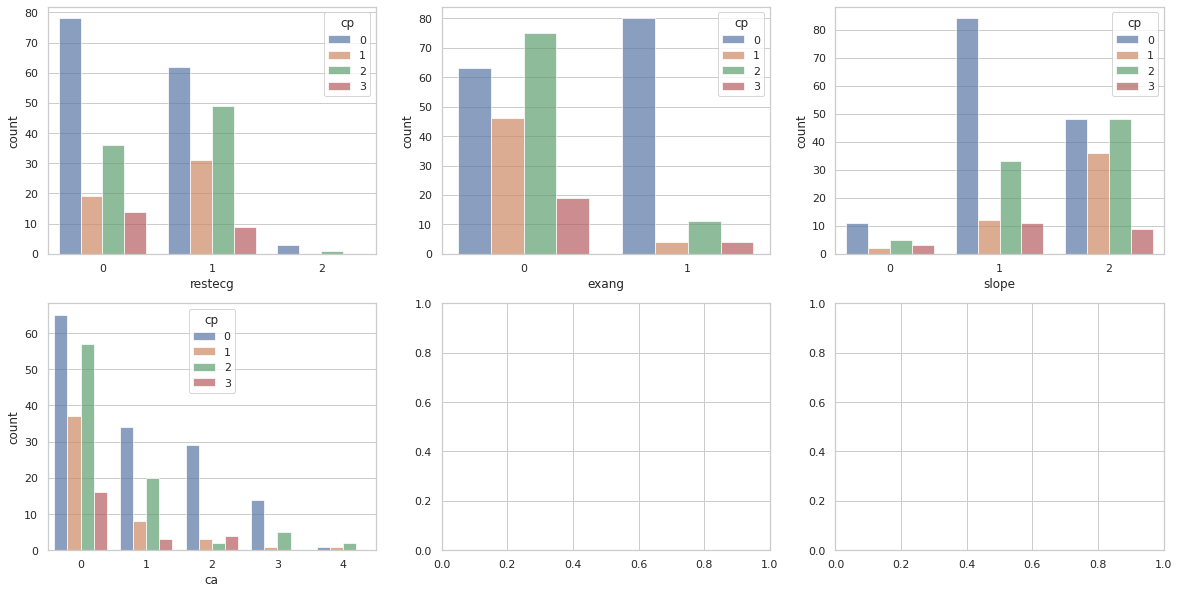

In [317]:
cols = ['restecg', 'exang', 'slope', 'ca']
fig, axes = plt.subplots(ceil(len(cols)/3), 3, figsize=(20,10))
for y, col in enumerate(cols):
    i, j = divmod(y, 3)
    sns.countplot(data=data, x=col, hue='cp', alpha=0.7, ax=axes[i, j])

+ при cp=0  почти всегда exang=0, при cp=2 почти всегда exang=0
+ при slope=1 как правило cp=0

проверим гипотезы:

In [318]:
X = ['cp'] * 4
Y = ['restecg', 'exang', 'slope', 'ca']
ksi(data, X, Y)

P-Value χ² теста между группами cp и restecg = 0.1513627409833443

P-Value χ² теста между группами cp и exang = 2.0449560429874252e-14

P-Value χ² теста между группами cp и slope = 0.00012222116762299602

P-Value χ² теста между группами cp и ca = 0.0011249053837924287



Наблюдаем сильную взаимосвязь между признаками cp и exang. 

**exang**

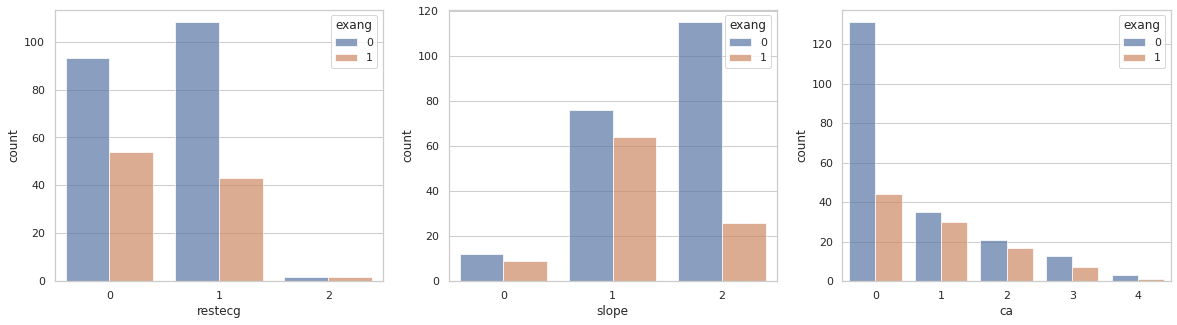

In [319]:
cols = ['restecg', 'slope', 'ca']
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
for y, col in enumerate(cols):
    sns.countplot(data=data, x=col, hue='exang', alpha=0.7, ax=axes[y])

+ По графикам видим, что если slope=2, то exang скорее всего равен 0
+ если ca=0, то скорее всего exang=0

In [320]:
X = ['exang'] * 4
Y = ['slope', 'ca']
ksi(data, X, Y)

P-Value χ² теста между группами exang и slope = 4.210860325908013e-06

P-Value χ² теста между группами exang и ca = 0.013826252470914017



У признака exang довольно сильная взаимосвязь  c признаками slope, cp, sex. Этот признак так же исключим из дальнейшего анализа.

In [321]:
col_for_del = ['exang']
data.drop(col_for_del, axis=1, inplace=True)
cols_cat = del_from_list(cols_cat, col_for_del)

# Анализ количественных признаков

## Распределение признаков

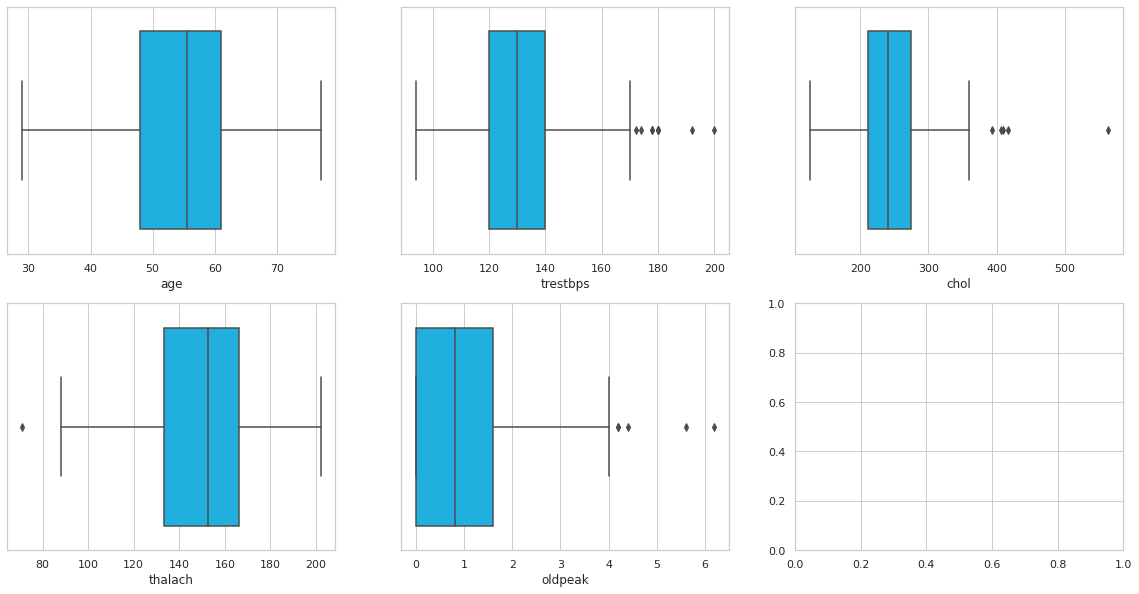

In [322]:
#ig_ = data[cols_num].hist(figsize=(16, 20), bins=50, color=COLOR_PLOT, edgecolor="black", xlabelsize=8, \
#                          ylabelsize=8)
fig, axes = plt.subplots(ceil(len(cols_num)/3), 3, figsize=(20,10))
for y, col in enumerate(cols_num):
    i, j = divmod(y, 3)
    sns.boxplot(data=data, x=col, color=COLOR_PLOT, ax=axes[i, j])

По графикам видим, что распределение признаков похоже на нормальное, кроме oldpeak. Кроме того виднеются выбросы. Надо от них избавиться, чтобы не вносили шум.

## Работа с выбросами

In [323]:
outliers1 = data[data["trestbps"] > 190].index.to_list()
outliers1

[223, 248]

In [324]:
outliers2 = data[data["chol"] > 500].index.to_list()
outliers2

[85]

In [325]:
outliers3 = data[data["thalach"] < 80].index.to_list()
outliers3

[272]

In [326]:
outliers4 = data[data["oldpeak"] > 5].index.to_list()
outliers4

[204, 221]

In [327]:
outliers = list(set(outliers1 + outliers2 + outliers3 + outliers4))
outliers

[204, 272, 85, 248, 221, 223]

In [328]:
data.shape

(302, 11)

In [329]:
data = data.drop(outliers)
data.shape

(296, 11)

## Влияние признаков на целевую переменную

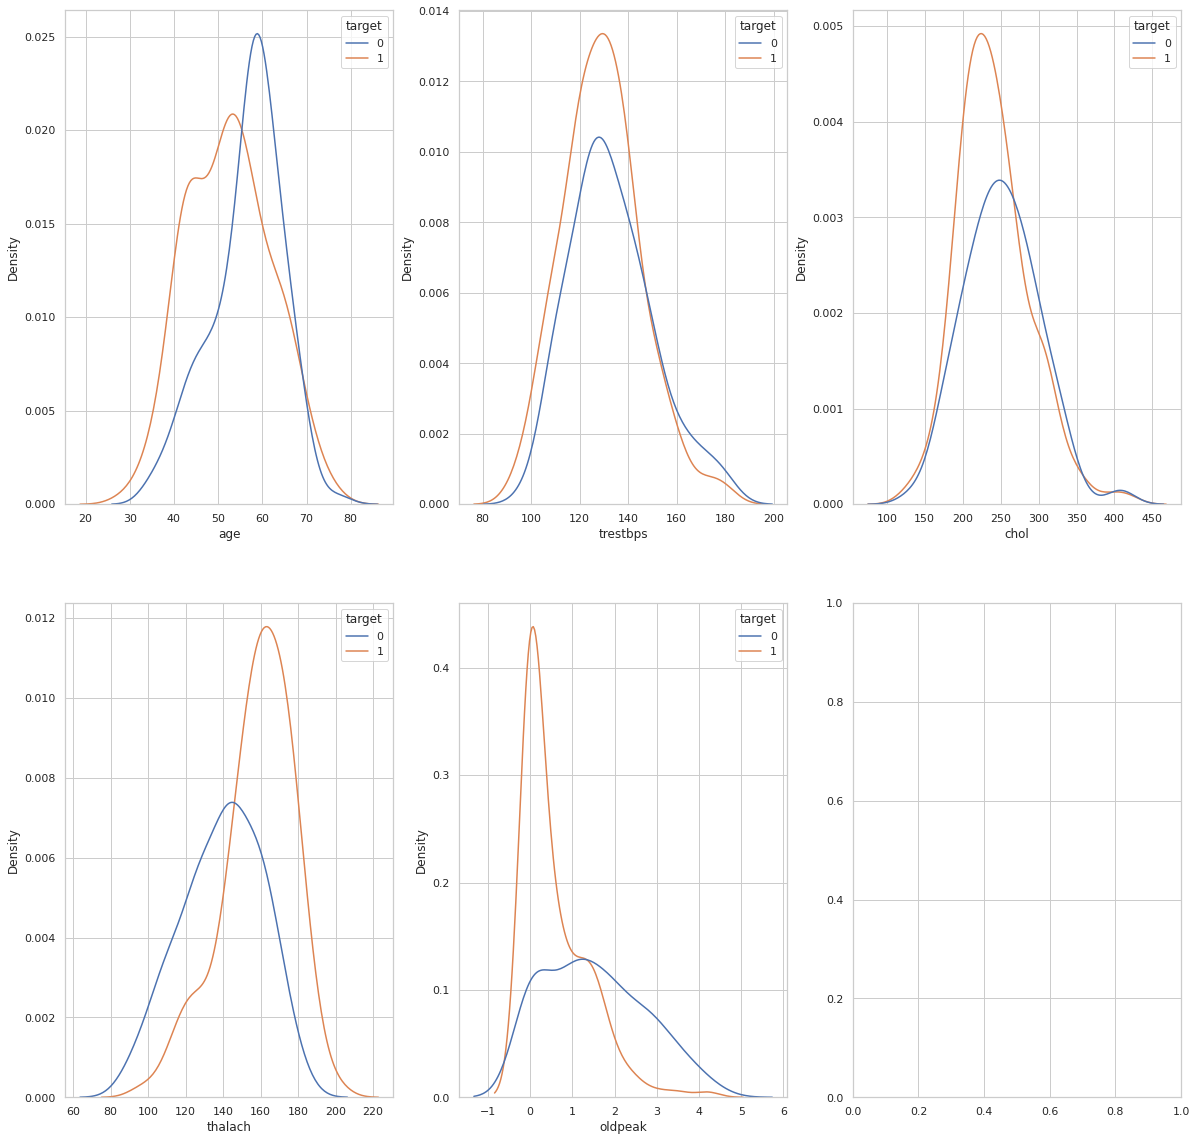

In [330]:
fig, axes = plt.subplots(ceil(len(cols_num)/3), 3, figsize=(20,20))
for y, col in enumerate(cols_num):
    i, j = divmod(y, 3)
    sns.kdeplot(data=data, x=col, hue='target', ax=axes[i,j])

Выводы из графиков:

Шансы приступа ниже для значений:
+ age може+но разбить на группы: до 55 лет шанс приступа выше, как и для группы 69-80.
+ trestbps дучше значения после 145 
+ chol - лучше значения до 160 и после 270
+ thalach - луше более низкие значения, тк при низких значениях меньше шанс приступа, при значении > 145 риск приступа становится выше
+ oldpeak лучше чтоб было значение выше, тк до 1.2 выше шанс приступа, после - ниже шанс приступа

Проведем t-тест для признаков trestbps и chol, у них средние значения выглядят одинаково, чтобы посмотреть статистически значимо или нет это различие:
H0: зависимости целевого признака target от этих признаков нет

**target и trestbps**

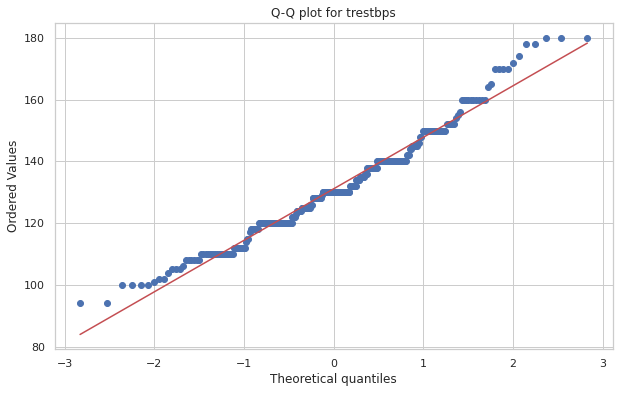

In [331]:
# для начала проверим похоже ли распределение зависимой переменной trestbps на нормальное:
plt.figure(figsize=(10,6))
probplot(data['trestbps'], plot= plt, dist="norm")
plt.title('Q-Q plot for trestbps')
plt.show()

Распределение похоже на нормальное, соотв. можем провести t-test

In [332]:
# посмотрим на средние значения trestbps для приступа и нет
data[data.target == 1].trestbps.mean()

129.33742331288343

In [333]:
data[data.target == 0].trestbps.mean()

133.34586466165413

кажется, значение совсем не велико. Мы проедем двусторонний t-test, где:
+ H0: группы одинаковы, не зависимо от target
+ H1: группы статистически значимо различаются

In [334]:
attack = data[data.target == 1].trestbps
non_attack = data[data.target == 0].trestbps

st,p = ttest_ind(attack,non_attack)
print('P-value :', p)

P-value : 0.04084832366864277


P-value < 0.05, делаем вывод, что средние все же статистически значимо различаются

**target и chol**

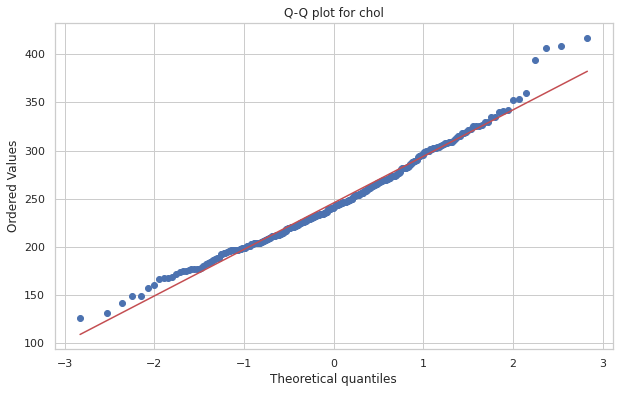

In [335]:
# для начала проверим похоже ли распределение зависимой переменной chol на нормальное:
plt.figure(figsize=(10,6))
probplot(data['chol'], plot= plt, dist="norm")
plt.title('Q-Q plot for chol')
plt.show()

за исключением нескольких выбросов распределение нормальное. 

Проведем t-test для наблюдений, исключив точки, отклоняющиеся от нормального распределения

In [336]:
# посмтотрим на средние значения
data[(data.target == 1) & (data.chol < 375)].chol.mean()

238.62111801242236

In [337]:
data[(data.target == 0) & (data.chol < 375)].chol.mean()

249.19847328244273

In [338]:
#проведем эксперимент - t test без выбросов, которые портят нормальность распределения
attack = data[(data.target == 1) & (data.chol < 375)].chol
non_attack = data[(data.target == 0) & (data.chol < 375)].chol
_, p = ttest_ind(attack, non_attack)
print('P-value :', p)

P-value : 0.045463151142327726


P-value < 0.05, делаем вывод, что средние статистически значимо различаются

## Корреляционный анализ

In [339]:
data_num_corr = data[cols_num]

In [340]:
# не у всех переменных распределение нормальное, поэтому используем непереметрический тест спирмена на корреляцию
corr_matrix = data_num_corr.corr(method='spearman')
corr_matrix


,age,trestbps,chol,thalach,oldpeak
age,1.000000,0.303414,0.191748,-0.395343,0.258754
trestbps,0.303414,1.000000,0.138749,-0.046346,0.149666
chol,0.191748,0.138749,1.000000,-0.053713,0.047743
thalach,-0.395343,-0.046346,-0.053713,1.000000,-0.421617
oldpeak,0.258754,0.149666,0.047743,-0.421617,1.000000


In [341]:
#для лучшей визуализации обнуляем корреляции, которые ниже заданного порога
corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0

<AxesSubplot:>

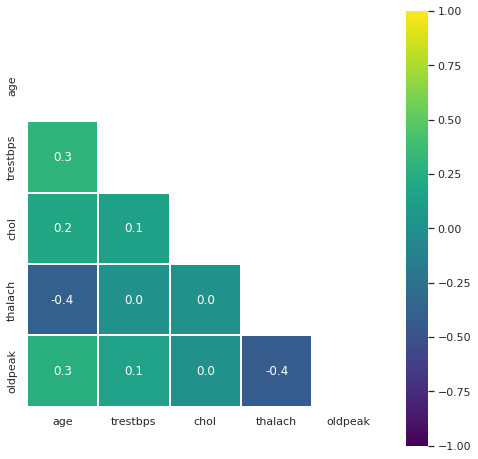

In [342]:
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"
sns.heatmap(corr_matrix, mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, 
            annot=True, fmt=".1f")

Видим самую сильную корреляцию между признаками thalach и oldpeak, тем не менее, она не критичная и исключать признаки мы не будем

#  Feature engineering

Введем признак Age status, используя данные с п.6.3

In [343]:
data['AgeStatus'] = np.nan
data.loc[data.age < 55, 'AgeStatus'] = '0-55'
data.loc[(data.age >= 55) & (data.age < 69), 'AgeStatus'] = '55-69'
data.AgeStatus.fillna('>69', inplace=True)
data.head()

,age,sex,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,target,AgeStatus
0,63,1,3,145,233,0,150,2.3,0,0,1,55-69
1,37,1,2,130,250,1,187,3.5,0,0,1,0-55
2,41,0,1,130,204,0,172,1.4,2,0,1,0-55
3,56,1,1,120,236,1,178,0.8,2,0,1,55-69
4,57,0,0,120,354,1,163,0.6,2,0,1,55-69


<AxesSubplot:xlabel='AgeStatus', ylabel='count'>

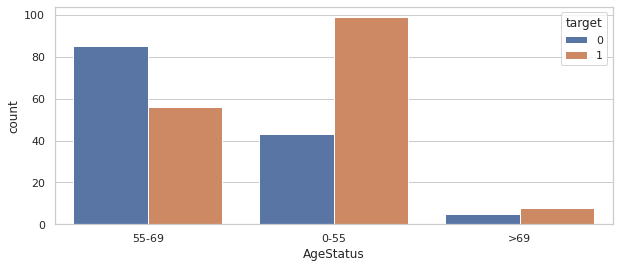

In [344]:
plt.figure(figsize=(10,4))
sns.countplot(data=data, x='AgeStatus', hue='target')

График нам еще раз показал, что в возрасте 0-55 больше шанс приступа, для группы 55-69 - ситуация обратная

In [345]:
cols_cat = add_into_list(cols_cat, 'AgeStatus')

# Подготовка данных к моделированию

## Разделение выборки на признаки и целевую переменную

In [346]:
X = data.drop(columns=['target'], axis=1).copy()
y = data.target.copy()
X.head()

,age,sex,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,AgeStatus
0,63,1,3,145,233,0,150,2.3,0,0,55-69
1,37,1,2,130,250,1,187,3.5,0,0,0-55
2,41,0,1,130,204,0,172,1.4,2,0,0-55
3,56,1,1,120,236,1,178,0.8,2,0,55-69
4,57,0,0,120,354,1,163,0.6,2,0,55-69


## Удаление признаков

удалим наш признак age, тк мы его заменили на AgeStatus

In [347]:
col_for_del = ['age']
X = X.drop(col_for_del, axis=1)

In [348]:
cols_num = del_from_list(cols_num, col_for_del)
cols_num

array(['chol', 'oldpeak', 'thalach', 'trestbps'], dtype='<U8')

## Нормализация числовых признаков


In [349]:
X[cols_num].head()

,chol,oldpeak,thalach,trestbps
0,233,2.3,150,145
1,250,3.5,187,130
2,204,1.4,172,130
3,236,0.8,178,120
4,354,0.6,163,120


In [350]:
sc = StandardScaler()
X[cols_num] = sc.fit_transform(X[cols_num])
X[cols_num].head()

,chol,oldpeak,thalach,trestbps
0,-0.259627,1.197010,0.006805,0.826920
1,0.091379,2.303667,1.662927,-0.067919
2,-0.858400,0.367017,0.991526,-0.067919
3,-0.197685,-0.186312,1.260087,-0.664479
4,2.238705,-0.370755,0.588686,-0.664479


# Кодирование Категориальных признаков

In [351]:
X[cols_cat]

,ca,cp,restecg,sex,slope,AgeStatus
0,0,3,0,1,0,55-69
1,0,2,1,1,0,0-55
2,0,1,0,0,2,0-55
3,0,1,1,1,2,55-69
4,0,0,1,0,2,55-69
...,...,...,...,...,...,...
298,0,0,1,0,1,55-69
299,0,3,1,1,1,0-55
300,2,0,1,1,1,55-69
301,1,0,1,1,1,55-69


sex кодировать не будем - там всего 2 значения 0 и 1

In [352]:
X = pd.get_dummies(X, columns=[col for col in cols_cat if col != 'sex'])
X.head()

,sex,trestbps,chol,thalach,oldpeak,ca_0,ca_1,ca_2,ca_3,ca_4,...,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,AgeStatus_0-55,AgeStatus_55-69,AgeStatus_>69
0,1,0.826920,-0.259627,0.006805,1.197010,1,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
1,1,-0.067919,0.091379,1.662927,2.303667,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
2,0,-0.067919,-0.858400,0.991526,0.367017,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,1,-0.664479,-0.197685,1.260087,-0.186312,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0,-0.664479,2.238705,0.588686,-0.370755,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


# Моделирование

## Сравнение простых моделей с параметрами по умолчанию для выбора наилучшей модели

Будем сравнивать предсказания следующих методов классификации:

Support Vector Machines
Random Forests
Logistic Regression

In [353]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [354]:
models = [SVC(class_weight='balanced', random_state=RANDOM_STATE),  RandomForestClassifier(class_weight='balanced'), LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=3000)]
for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_valid)
    print(f'model: {str(m)}')
    print(f'f1_score: {str(f1_score(y_valid, y_pred))}')
    print('_'*30, '\n')

model: SVC(class_weight='balanced', random_state=100)
f1_score: 0.8709677419354839
______________________________ 

model: RandomForestClassifier(class_weight='balanced')
f1_score: 0.8571428571428571
______________________________ 

model: LogisticRegression(class_weight='balanced', max_iter=3000, random_state=100)
f1_score: 0.8888888888888888
______________________________ 



Модели SVC и LogisticRegression показали лучшие результаты, давайте возьмем обе эти модели, построив ансамбль

## Подбор параметров

In [355]:
classifiers = {
    'SVC' : SVC(class_weight='balanced', random_state=RANDOM_STATE),
    'LogisticRegression' : LogisticRegression(max_iter=3000, class_weight='balanced', \
                                              random_state=RANDOM_STATE, n_jobs=-1)
    
}

svc_grid = {
    'kernel':('linear', 'rbf'), 
#     'C':[0.1, 0.7, 0.5, 1, 2]
}
logist_grid = {
    'C': [0.1, 1, 1.5, 3]
}

grid = {
    'SVC' : svc_grid,
    'LogisticRegression' : logist_grid
    
}

In [356]:
i=0
result_models = pd.DataFrame({'model': classifiers.keys(), 'Validation f1 score':np.zeros(len(classifiers)), \
                             'Best params': np.zeros(len(classifiers))})
clf_best_params = classifiers.copy()                            
for key, m in classifiers.items():
    
    cv = StratifiedKFold(n_splits=NUM_SPLIT_FOR_GRID, shuffle=True, random_state=RANDOM_STATE)
    
    clf = GridSearchCV(estimator=m, param_grid=grid[key], n_jobs=-1, cv=cv, \
                       scoring=make_scorer(f1_score))
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    result_models.iloc[i, 1] = f1_score(y_valid, y_pred)

    
    result_models.iloc[i, 2] = str(clf.best_params_)
    
    clf_best_params[key] = clf.best_params_
    i += 1

In [357]:
result_models

,model,Validation f1 score,Best params
0,SVC,0.875000,{'kernel': 'linear'}
1,LogisticRegression,0.888889,{'C': 1}


In [358]:
clf_best_params

{'SVC': {'kernel': 'linear'}, 'LogisticRegression': {'C': 1}}

## Построение модели и предсказание

In [359]:
# определяем лучшую модель
best_classifiers = {
    "SVC" : SVC(**clf_best_params["SVC"],probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    "LogisticRegression" : LogisticRegression(**clf_best_params["LogisticRegression"], max_iter=3000, \
                                              class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
}



In [360]:
preds = np.zeros(len(X_valid))
for key, classifier in best_classifiers.items():
    clf = classifier
    clf.fit(X_train, y_train)
           
    preds += clf.predict_proba(X_valid)[:,1]

# результат - это средний результат по всем классификаторам    
preds = preds/len(best_classifiers)
preds 

array([0.87623305, 0.07056832, 0.53781677, 0.17878859, 0.10299264,
       0.35981115, 0.95216255, 0.58404259, 0.94902969, 0.96710395,
       0.30353168, 0.91238156, 0.05368744, 0.37840977, 0.88514044,
       0.45772359, 0.76629314, 0.41242311, 0.96251162, 0.01274051,
       0.22745472, 0.85430075, 0.15120552, 0.57551317, 0.0346033 ,
       0.64563188, 0.32900062, 0.03532672, 0.97412496, 0.98277751,
       0.31818738, 0.8124065 , 0.92829017, 0.29926306, 0.0249162 ,
       0.78773339, 0.10693776, 0.24211953, 0.93703423, 0.02969575,
       0.72261789, 0.01628488, 0.72900668, 0.9948442 , 0.66283721,
       0.82292206, 0.40071348, 0.52749778, 0.97307515, 0.03275796,
       0.91183136, 0.19316376, 0.75484669, 0.60097817, 0.85717727,
       0.08783439, 0.91885243, 0.9241272 , 0.57902495, 0.653684  ])

Text(0.5, 0, 'Probability')

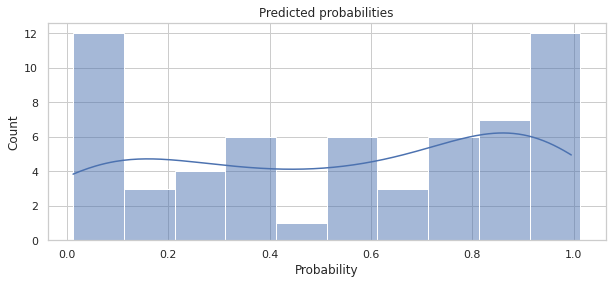

In [361]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.1, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

По графику видим, что подавляющее большинство предсказывается обеими моделями одинаково, спорных от 0.4 до 0.5 всего 1 наюлюдение

Выберем порог предсказания 1-го класса [0.5,1]

In [362]:
y_pred = (preds>0.5).astype(int)
y_pred

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [363]:
f1_score(y_valid, y_pred)

0.8923076923076922

Благодаря ансамблю из двух моделей нам удалось увеличить точность предсказания

## Анализ результатов

In [364]:
print('Confusion matrix:')
print(confusion_matrix(y_valid, y_pred))
print('Classification Report:')
print(classification_report(y_valid, y_pred))

Confusion matrix:
[[24  5]
 [ 2 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        29
           1       0.85      0.94      0.89        31

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



Визуализируем полученные результаты при помощи confusion matrix


Text(66.5, 0.5, 'Actual')

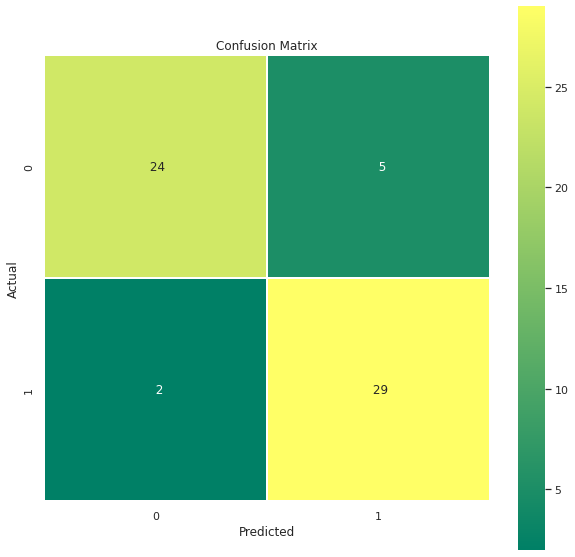

In [365]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_valid, y_pred), linewidths=0.1, square=True, annot=True, cmap='summer', fmt='3.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Неверно классифицировано только 7 наблюдений, причем из тех, у кого в реальности случился приступ, только 2х из них мы предсказали не верно. В реальной задаче следовало бы использовать f beta score, увеличивая значимость полноты, чтобы постараться определить эти 2 наблюдения, при этом ухудшив точность.